In [1]:
import os, sys, torch, glob
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import imageio

from torch import utils

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define the parameters

In [2]:
from functions.param_loader import Params, SLMInitMode, PropagatorMode

params                       = Params()
params.focal_length          = 100e-03
params.grayscale             = False
params.simulation_resolution = 5e-06
params.num_depths            = 20           # number of depths to quantize the depth map to
params.num_focuses           = 6            # number of focuses to capture on the sensor
params.num_iters_per_round   = 4
params.num_rounds            = 8
params.sensor_shape          = [1080, 1920] # [y, x]
params.eyepiece_focal_length = 40e-03
params.eye_diameter          = 5e-03
params.working_range         = 4.0
params.device                = 'cpu'

params.calculate_simulation_coordinates()
params.print()

focal_length : 0.1
aperture : 0.0254
eyepiece_focal_length : 0.04
eye_diameter : 0.005
eye_retina_distance : 0.025
grayscale : False
working_range : 4.0
C0 : 0.019337
d_slm_to_3dnominal : 0.1
simulation_resolution : 5e-06
oled_pixel_pitch : 4e-06
slm_pixel_pitch : 4e-06
sensor_pixel_pitch : 4e-06
sensor_shape : [1080, 1920]
num_depths : 12
num_focuses : 6
num_iters_per_round : 4
num_rounds : 8
wavelengths : 5.3e-07
num_channels : 3
device : cpu
N : 2120.0
dz_max : 0.0064
max_shift_by_slm : 0.006625000000000001
aperture_T2 : 0.005
aperture_T1 : 0.007916975749931577
d1_sim : 5e-06
c1_sim : -0.0053
N1_sim : 2120
d_sensor : 4e-06
Ny_sensor : 1080
Nx_sensor : 1920
cy_sensor : -0.00216
cx_sensor : -0.0038399999999999997


# Setup the simulator to generate a focal stack

We can create the ground truth focal stack using the time-multiplexed multifocal displays approach, which propagates the multiplane images for different distances to the sensor plane at different times but within one exposure time.  

In [3]:
from functions.focal_stack_simulator import FocalStackSimulator

### Instantiate the simulator
scene_name = 'Whiskey'
texture_path = f'scenes/png/{scene_name}_TextureMap.png'
diopter_path = f'scenes/png/{scene_name}_DiopterMap.png'
simulator = FocalStackSimulator(texture_path=texture_path, 
                                     diopter_path=diopter_path, 
                                     params=params,
                                     resize=True, 
                                     initiate_focal_stack=False, 
                                     propagator_type=PropagatorMode.TIMEMUL_MULTIFOCALS, 
                                     alpha = 1.6, 
                                     gamma = 1.0, 
                                     cropimage = True)

### Print out the shapes
print(f'texture_map_sampled shape   : {simulator.texture_image_sampled.shape}')
print(f'diopter_map_sampled shape   : {simulator.diopter_image_sampled.shape}')

torch.Size([1, 1, 3, 2120, 2120]) torch.Size([1, 1, 1, 2120, 2120])
texture_map_sampled shape   : torch.Size([1, 1, 3, 2120, 2120])
diopter_map_sampled shape   : torch.Size([1, 1, 1, 2120, 2120])


# Run simulation to generate a focal stack

In [4]:
focal_stack = simulator.simulate(cropimage=False)

Generating the focal stack: 100%|██████████| 8/8 [06:34<00:00, 49.27s/it]


# Visualize the result focal stack

We can visualize the difference between the input image and a propagated focal stack slice image. 

We can use the multiplane mask to keep out the regions out-of-focus.

We expect to see and can observe that regions in focus have smaller differences.

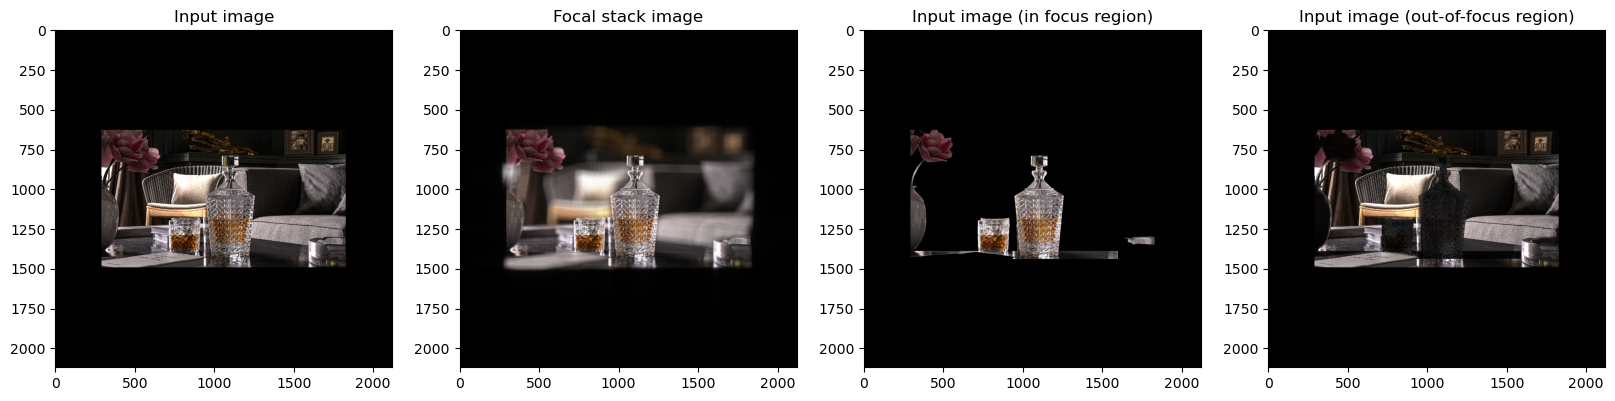

In [9]:
mpi_focus_mask = simulator.get_mpi_mask_focus()

focal_stack_infocus = focal_stack * mpi_focus_mask
focal_stack_display = focal_stack.squeeze()
img_idx = len(focal_stack_display)//2
focal_stack_slice = focal_stack_display[img_idx]
focal_stack_slice = focal_stack_slice.permute(1, 2, 0).detach().cpu().numpy()
focal_stack_infocus_slice = focal_stack_infocus.squeeze()[img_idx].permute(1, 2, 0).detach().cpu().numpy()

img_input = simulator.texture_image_sampled.squeeze().permute(1, 2, 0).detach().cpu().numpy()
img_input = img_input / np.max(img_input)

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
plt.imshow(img_input)
plt.title('Input image')
plt.subplot(1,4,2)
plt.imshow(focal_stack_slice)
plt.title('Focal stack image')
plt.subplot(1,4,3)
plt.imshow(focal_stack_infocus_slice)
plt.title('Input image (in focus region)')
plt.subplot(1,4,4)
plt.imshow(np.abs(focal_stack_infocus_slice - img_input))
plt.title('Input image (out-of-focus region)')
plt.show()

In [10]:
# mpi_mask_focus = dataset.show_mp_mask()

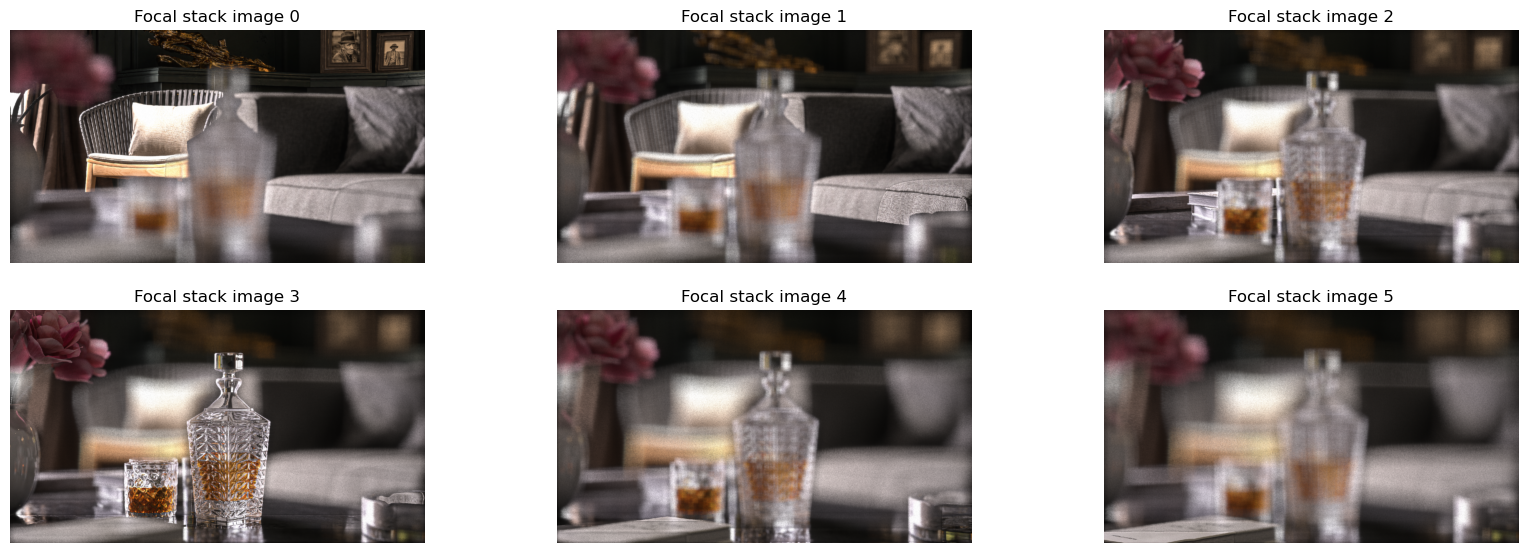

In [11]:
focal_stack_channel_last = simulator.show_focalstack(focal_stack_display, cropimage=True)

In [13]:
fps = 2
imageio.mimsave(f'results/{scene_name}_timemul_multifocals_result.gif', np.round(focal_stack_channel_last*255).astype(np.uint8), duration=1000*(1/fps), loop=0)